In [182]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

# Retina display
%config InlineBackend.figure_format = 'retina'

# PyTorch device CUDA0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [215]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())


# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'

In [216]:
### Case 1: Homoskedastic noise

# Generate data

torch.manual_seed(42)
N = 100
x_lin = torch.linspace(-1, 1, N)

f = lambda x: 0.5 * x**2 + 0.25 * x**3

eps = torch.randn(N) * 0.2

y = f(x_lin) + eps

# Move to GPU
x_lin = x_lin.to(device)
y = y.to(device)


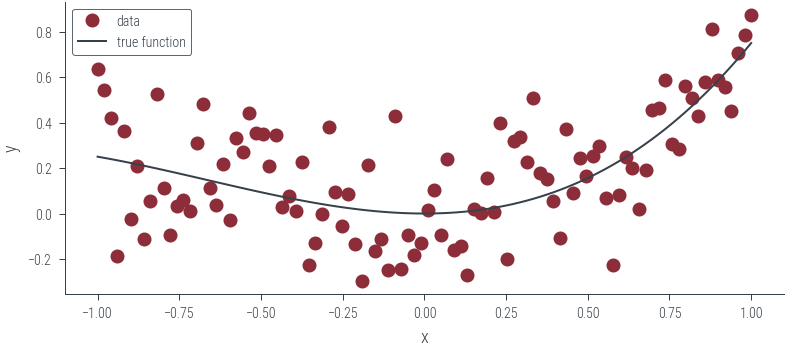

In [217]:
# Plot data and true function
plt.plot(x_lin.cpu(), y.cpu(), 'o', label='data')
plt.plot(x_lin.cpu(), f(x_lin).cpu(), label='true function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [218]:
#### Case 1.1 NN with homoskedastic noise

class HomoskedasticNNFixedNoise(torch.nn.Module):
    def __init__(self, n_hidden=10):
        super().__init__()
        self.fc1 = torch.nn.Linear(1, n_hidden)
        self.fc2 = torch.nn.Linear(n_hidden, n_hidden)
        self.fc3 = torch.nn.Linear(n_hidden, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        mu_hat = self.fc3(x)
        return mu_hat

In [219]:
def loss_homoskedastic_fixed_noise(model, x, y, log_noise_std):
    mu_hat = model(x).squeeze()
    assert mu_hat.shape == y.shape
    noise_std = torch.exp(log_noise_std).expand_as(mu_hat)
    dist = torch.distributions.Normal(mu_hat, noise_std)
    return -dist.log_prob(y).mean()


In [220]:
model_1 = HomoskedasticNNFixedNoise()
# Move to GPU
model_1.to(device)

HomoskedasticNNFixedNoise(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)

In [221]:
fixed_log_noise_std = torch.log(torch.tensor(0.5)).to(device)
loss_homoskedastic_fixed_noise(model_1, x_lin[:, None], y, fixed_log_noise_std)

tensor(0.3774, device='cuda:0', grad_fn=<NegBackward0>)

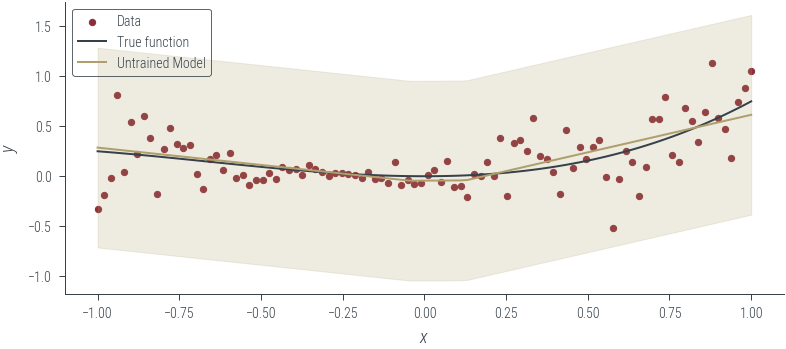

In [269]:
def plot_model_1(model, l="Untrained model", log_noise_param=fixed_log_noise_std, aleatoric=True):

    with torch.no_grad():
        y_hat = model(x_lin[:, None]).squeeze().cpu()
        std = torch.exp(log_noise_param).cpu()


    plt.scatter(x_lin.cpu(), y.cpu(), s=10, color='C0', label='Data')
    plt.plot(x_lin.cpu(), f(x_lin.cpu()), color='C1', label='True function')
    plt.plot(x_lin.cpu(), y_hat.cpu(), color='C2', label=l)
    if aleatoric:
        # Plot the +- 2 sigma region (where sigma is fixed to 0.2)
        plt.fill_between(x_lin.cpu(), y_hat - 2 * std, y_hat + 2 * std, alpha=0.2, color='C2')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend()

plot_model_1(model_1, "Untrained Model")


In [223]:
def train(model, loss_func, params, x, y, log_noise_param, n_epochs=1000, lr=0.01):
    optimizer = torch.optim.Adam(params, lr=lr)
    for epoch in range(n_epochs):
        # Print every 10 epochs
        if epoch % 50 == 0:
            noise_std = torch.exp(log_noise_param)  # Calculate the noise standard deviation
            print(f'Epoch {epoch}: loss {loss_func(model, x, y, log_noise_param)}')
        optimizer.zero_grad()
        loss = loss_func(model, x, y, log_noise_param)
        loss.backward()
        optimizer.step()
    return loss.item()


In [224]:
params = list(model_1.parameters())
train(model_1, loss_homoskedastic_fixed_noise, params, x_lin[:, None], y, fixed_log_noise_std, n_epochs=1000, lr=0.001)

Epoch 0: loss 0.37737852334976196
Epoch 50: loss 0.36576324701309204
Epoch 100: loss 0.36115822196006775
Epoch 150: loss 0.35357466340065
Epoch 200: loss 0.3445783853530884
Epoch 250: loss 0.33561965823173523
Epoch 300: loss 0.3253604769706726
Epoch 350: loss 0.3168313503265381
Epoch 400: loss 0.3112250566482544
Epoch 450: loss 0.30827972292900085
Epoch 500: loss 0.30689162015914917
Epoch 550: loss 0.30621206760406494
Epoch 600: loss 0.3059086203575134
Epoch 650: loss 0.30568134784698486
Epoch 700: loss 0.3052031695842743
Epoch 750: loss 0.305046409368515
Epoch 800: loss 0.30500170588493347
Epoch 850: loss 0.3049851953983307
Epoch 900: loss 0.30497878789901733
Epoch 950: loss 0.3049766719341278


0.3049757182598114

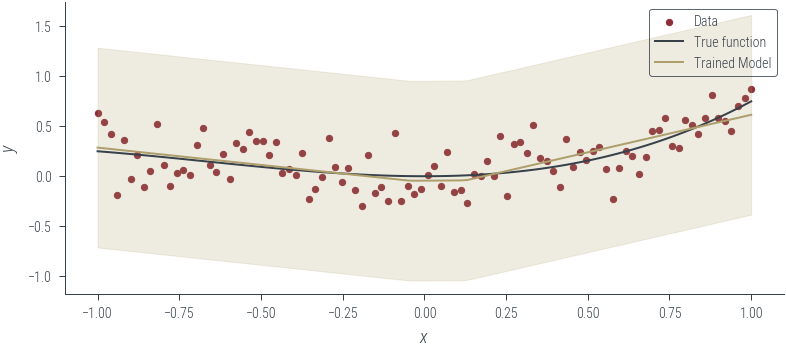

In [225]:
plot_model_1(model_1, "Trained Model")

#### Case 1.2  NN with homoskedastic noise (learned)

The model is the same as in case 1.1, but the noise is learned from the data. Thus, we need to modify the loss function to include the noise parameter $\sigma$.


In [226]:
# Define the loss function
def loss_homoskedastic_learned_noise(model, x, y, noise):
    mean = model(x)
    dist = torch.distributions.Normal(mean, noise)
    return -dist.log_prob(y).mean()

In [227]:
model_2 = HomoskedasticNNFixedNoise()
log_noise_param = torch.nn.Parameter(torch.tensor(0.0).to(device))

# Move to GPU
model_2.to(device)

HomoskedasticNNFixedNoise(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)

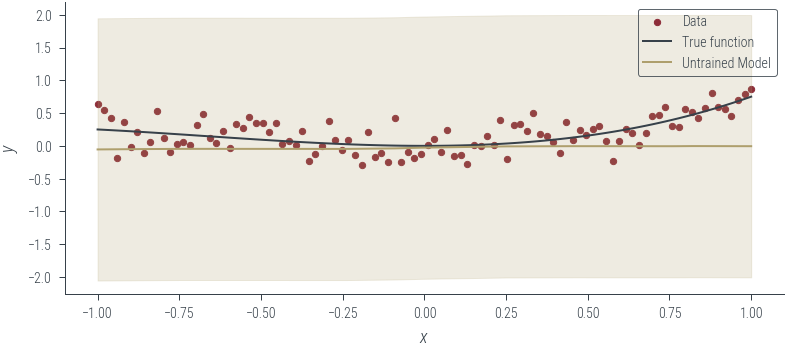

In [228]:
# Plot the untrained model
plot_model_1(model_2, "Untrained Model", log_noise_param=log_noise_param)

In [229]:
# Train the model
params = list(model_2.parameters()) + [log_noise_param]

train(model_2, loss_homoskedastic_fixed_noise, params, x_lin[:, None], y, log_noise_param, n_epochs=1000, lr=0.01)

Epoch 0: loss 0.9752065539360046
Epoch 50: loss 0.4708317220211029
Epoch 100: loss 0.06903044134378433
Epoch 150: loss -0.19027572870254517
Epoch 200: loss -0.31068307161331177
Epoch 250: loss -0.3400699496269226
Epoch 300: loss -0.3422872722148895
Epoch 350: loss -0.3424949049949646
Epoch 400: loss -0.3450787365436554
Epoch 450: loss -0.348661333322525
Epoch 500: loss -0.3499276638031006
Epoch 550: loss -0.34957197308540344
Epoch 600: loss -0.3541718125343323
Epoch 650: loss -0.3527887165546417
Epoch 700: loss -0.3585814833641052
Epoch 750: loss -0.3589327931404114
Epoch 800: loss -0.3592424690723419
Epoch 850: loss -0.3592303693294525
Epoch 900: loss -0.3538239300251007
Epoch 950: loss -0.35970067977905273


-0.3580436110496521

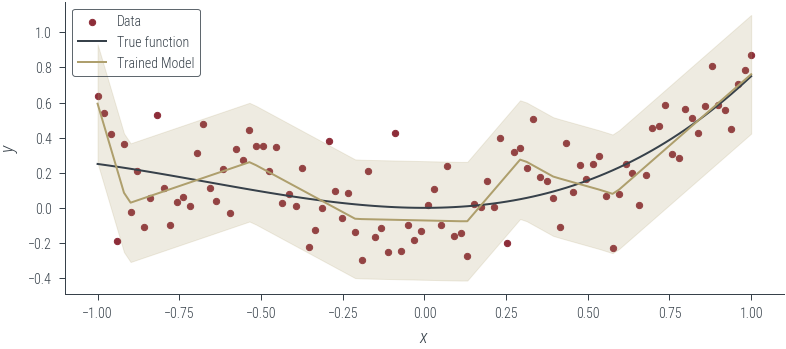

In [230]:
# Plot the trained model
plot_model_1(model_2, "Trained Model", log_noise_param=log_noise_param)

In [231]:
#### Heteroskedastic noise model

class HeteroskedasticNN(torch.nn.Module):
    def __init__(self, n_hidden=10):
        super().__init__()
        self.fc1 = torch.nn.Linear(1, n_hidden)
        self.fc2 = torch.nn.Linear(n_hidden, n_hidden)
        self.fc3 = torch.nn.Linear(n_hidden, 2) # we learn both mu and log_noise_std
        
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        z = self.fc3(x)
        mu_hat = z[:, 0]
        log_noise_std = z[:, 1]
        return mu_hat, log_noise_std

In [232]:
model_3 = HeteroskedasticNN()
# Move to GPU
model_3.to(device)



AttributeError: 'tuple' object has no attribute 'squeeze'

In [239]:
def _plot(y_hat, std, l="Untrained model"):
    plt.scatter(x_lin.cpu(), y.cpu(), s=10, color='C0', label='Data')
    plt.plot(x_lin.cpu(), f(x_lin.cpu()), color='C1', label='True function')
    plt.plot(x_lin.cpu(), y_hat.cpu(), color='C2', label=l)
    # Plot the +- 2 sigma region (where sigma is fixed to 0.2)
    plt.fill_between(x_lin.cpu(), y_hat - 2 * std, y_hat + 2 * std, alpha=0.2, color='C2')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend()

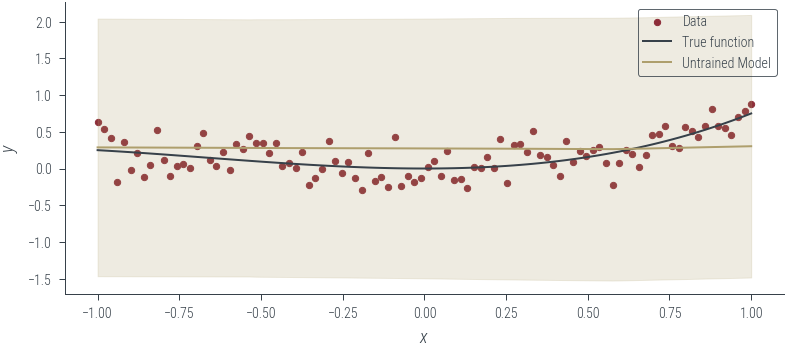

In [240]:
def plot_heteroskedastic_model(model, l="Untrained model", log_noise_param=fixed_log_noise_std):

    with torch.no_grad():
        y_hat, log_noise_std = model(x_lin[:, None])
        std = torch.exp(log_noise_std).cpu()
        y_hat = y_hat.cpu()
    
    _plot(y_hat, std, l)


plot_heteroskedastic_model(model_3, "Untrained Model")


In [243]:
# Train
params = list(model_3.parameters())

def loss_heteroskedastic(model, x, y):
    mu_hat, log_noise_std = model(x)
    noise_std = torch.exp(log_noise_std)
    dist = torch.distributions.Normal(mu_hat, noise_std)
    return -dist.log_prob(y).mean()

def train_heteroskedastic(model, loss_func, params, x, y, n_epochs=1000, lr=0.01):
    optimizer = torch.optim.Adam(params, lr=lr)
    for epoch in range(n_epochs):
        # Print every 10 epochs
        if epoch % 50 == 0:
            print(f'Epoch {epoch}: loss {loss_func(model, x, y)}')
        optimizer.zero_grad()
        loss = loss_func(model, x, y)
        loss.backward()
        optimizer.step()
    return loss.item()

train_heteroskedastic(model_3, loss_heteroskedastic, params, x_lin[:, None], y, n_epochs=1000, lr=0.001)

Epoch 0: loss 0.8471216559410095
Epoch 50: loss 0.5730974674224854
Epoch 100: loss 0.21664416790008545
Epoch 150: loss -0.0901612937450409
Epoch 200: loss -0.18870659172534943
Epoch 250: loss -0.21993499994277954
Epoch 300: loss -0.23635315895080566
Epoch 350: loss -0.24628539383411407
Epoch 400: loss -0.2610110640525818
Epoch 450: loss -0.2744489908218384
Epoch 500: loss -0.28417855501174927
Epoch 550: loss -0.29257726669311523
Epoch 600: loss -0.30057546496391296
Epoch 650: loss -0.3061988353729248
Epoch 700: loss -0.31035324931144714
Epoch 750: loss -0.3138866126537323
Epoch 800: loss -0.3167155683040619
Epoch 850: loss -0.3188284635543823
Epoch 900: loss -0.32069918513298035
Epoch 950: loss -0.32232046127319336


-0.323951780796051

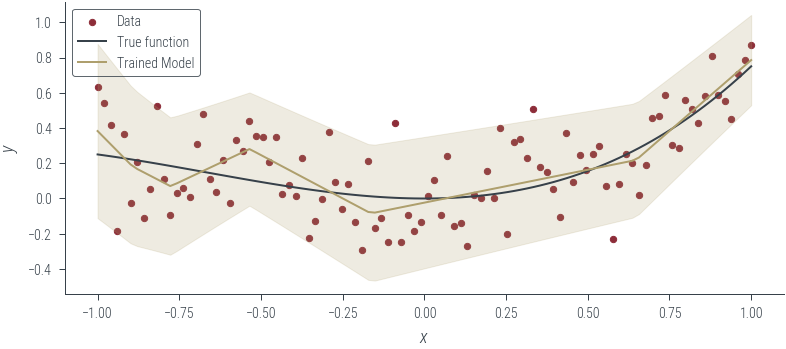

In [244]:
# Plot the trained model
plot_heteroskedastic_model(model_3, "Trained Model")

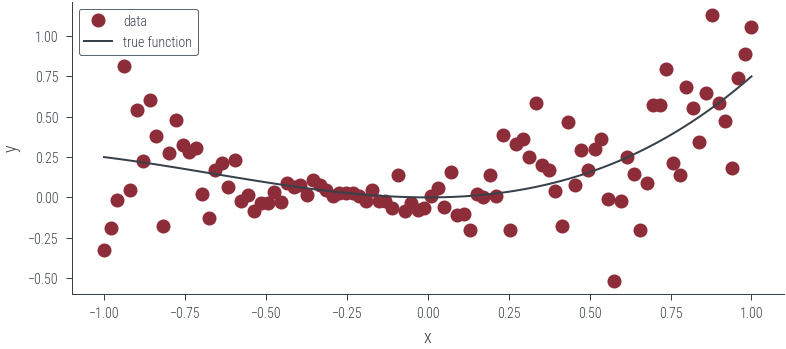

In [249]:
# Now, let us try these on some data that is not homoskedastic

# Generate data

torch.manual_seed(42)
N = 100
x_lin = torch.linspace(-1, 1, N)

f = lambda x: 0.5 * x**2 + 0.25 * x**3

eps = torch.randn(N) * (0.1 + 0.4 * x_lin)

y = f(x_lin) + eps

# Move to GPU
x_lin = x_lin.to(device)
y = y.to(device)

# Plot data and true function
plt.plot(x_lin.cpu(), y.cpu(), 'o', label='data')
plt.plot(x_lin.cpu(), f(x_lin).cpu(), label='true function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

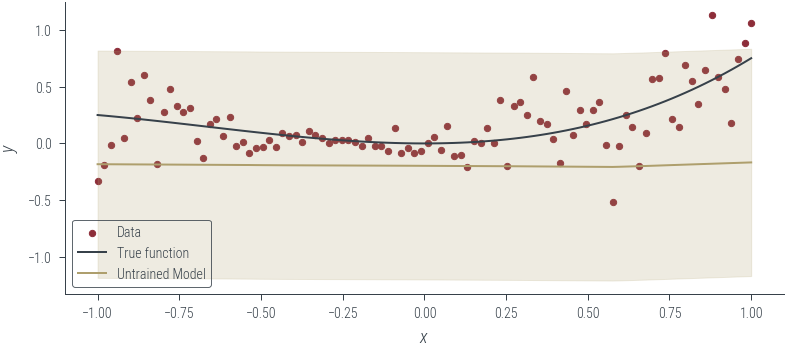

In [252]:
# Now, fit the homoskedastic model

model_4 = HomoskedasticNNFixedNoise()
# Move to GPU
model_4.to(device)

fixed_log_noise_std = torch.log(torch.tensor(0.5)).to(device)

# Plot the untrained model
plot_model_1(model_4, "Untrained Model", log_noise_param=fixed_log_noise_std)

# Train the model
params = list(model_4.parameters())

Epoch 0: loss 0.6589293479919434
Epoch 50: loss 0.4215749204158783
Epoch 100: loss 0.38480445742607117
Epoch 150: loss 0.3676103949546814
Epoch 200: loss 0.35454797744750977
Epoch 250: loss 0.3454076945781708
Epoch 300: loss 0.3388737440109253
Epoch 350: loss 0.33503660559654236
Epoch 400: loss 0.33316338062286377
Epoch 450: loss 0.3321770429611206
Epoch 500: loss 0.3315906524658203
Epoch 550: loss 0.3312351405620575
Epoch 600: loss 0.33097800612449646
Epoch 650: loss 0.330804705619812
Epoch 700: loss 0.3306663930416107
Epoch 750: loss 0.33054396510124207
Epoch 800: loss 0.3304164707660675
Epoch 850: loss 0.33028045296669006
Epoch 900: loss 0.33013835549354553
Epoch 950: loss 0.3299860656261444


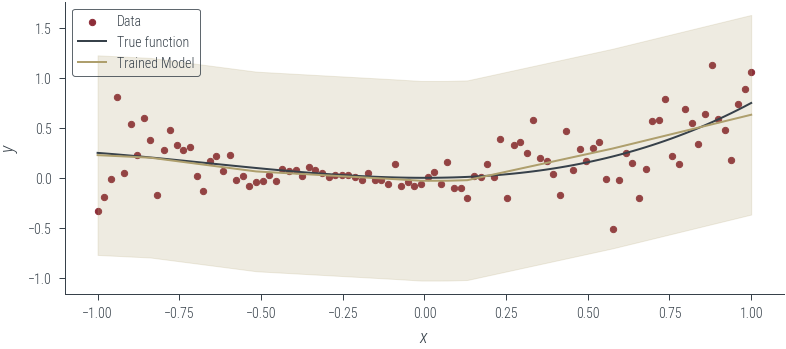

In [253]:

train(model_4, loss_homoskedastic_fixed_noise, params, x_lin[:, None], y, fixed_log_noise_std, n_epochs=1000, lr=0.001)

# Plot the trained model
plot_model_1(model_4, "Trained Model", log_noise_param=fixed_log_noise_std)

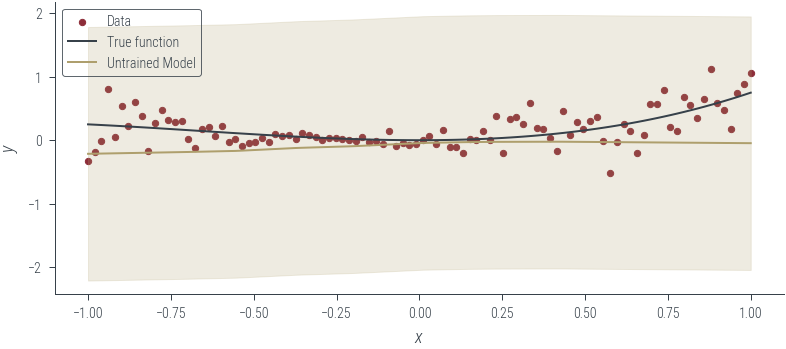

In [254]:
# Now, fit the homoskedastic model with learned noise

model_5 = HomoskedasticNNFixedNoise()
log_noise_param = torch.nn.Parameter(torch.tensor(0.0).to(device))

# Move to GPU
model_5.to(device)

# Plot the untrained model
plot_model_1(model_5, "Untrained Model", log_noise_param=log_noise_param)



Epoch 0: loss 0.9960418343544006
Epoch 50: loss 0.49364227056503296
Epoch 100: loss 0.12215663492679596
Epoch 150: loss -0.10395683348178864
Epoch 200: loss -0.19490668177604675
Epoch 250: loss -0.2231469750404358
Epoch 300: loss -0.23898643255233765
Epoch 350: loss -0.2505432069301605
Epoch 400: loss -0.23449184000492096
Epoch 450: loss -0.2479456216096878
Epoch 500: loss -0.25138041377067566
Epoch 550: loss -0.25380513072013855
Epoch 600: loss -0.2578001320362091
Epoch 650: loss -0.2586041986942291
Epoch 700: loss -0.25800997018814087
Epoch 750: loss -0.25759875774383545
Epoch 800: loss -0.259513258934021
Epoch 850: loss -0.25965380668640137
Epoch 900: loss -0.2558659017086029
Epoch 950: loss -0.2555006146430969


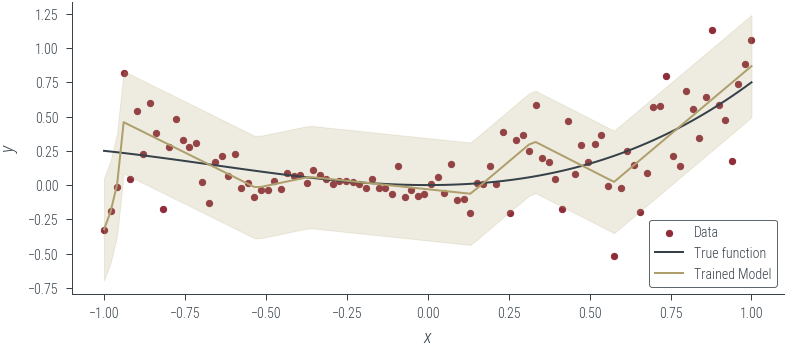

In [255]:
# Train the model
params = list(model_5.parameters()) + [log_noise_param]

train(model_5, loss_homoskedastic_fixed_noise, params, x_lin[:, None], y, log_noise_param, n_epochs=1000, lr=0.01)

# Plot the trained model
plot_model_1(model_5, "Trained Model", log_noise_param=log_noise_param)

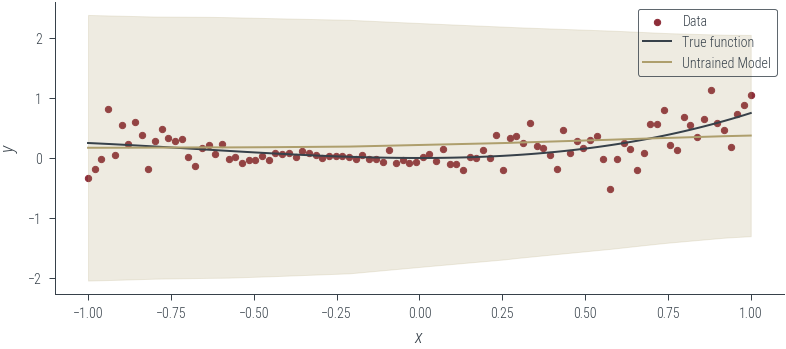

In [256]:
# Now, fit the heteroskedastic model

model_6 = HeteroskedasticNN()
# Move to GPU
model_6.to(device)

# Plot the untrained model
plot_heteroskedastic_model(model_6, "Untrained Model")

In [257]:
# Train the model
params = list(model_6.parameters())

train_heteroskedastic(model_6, loss_heteroskedastic, params, x_lin[:, None], y, n_epochs=1000, lr=0.001)


Epoch 0: loss 0.956428050994873
Epoch 50: loss 0.561416506767273
Epoch 100: loss 0.13541047275066376
Epoch 150: loss 0.07323385775089264
Epoch 200: loss 0.012474002316594124
Epoch 250: loss -0.07754731923341751
Epoch 300: loss -0.17909125983715057
Epoch 350: loss -0.2570819556713104
Epoch 400: loss -0.3168020248413086
Epoch 450: loss -0.360955148935318
Epoch 500: loss -0.3886547386646271
Epoch 550: loss -0.40671423077583313
Epoch 600: loss -0.420712947845459
Epoch 650: loss -0.43868833780288696
Epoch 700: loss -0.4533745348453522
Epoch 750: loss -0.46243199706077576
Epoch 800: loss -0.46816787123680115
Epoch 850: loss -0.47153788805007935
Epoch 900: loss -0.4743836522102356
Epoch 950: loss -0.4768517315387726


-0.4791721999645233

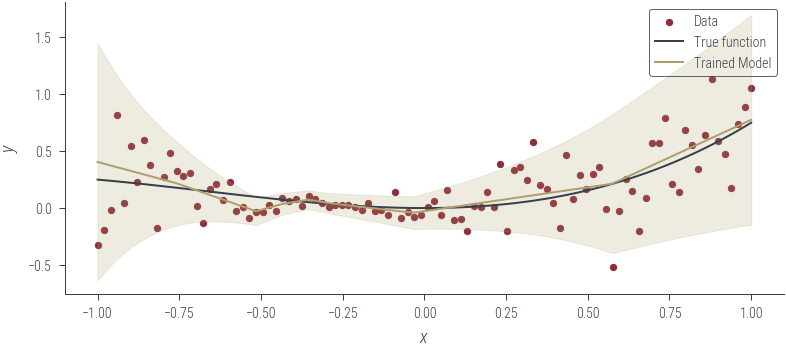

In [258]:
# Plot the trained model
plot_heteroskedastic_model(model_6, "Trained Model")

In [259]:
### Bayesian NN with Laplace approximation


In [262]:
from laplace import Laplace

In [301]:
model_7 = HomoskedasticNNFixedNoise()
# Move to GPU
model_7.to(device)

def negative_log_prior_last_layer(model):
    log_prior = torch.distributions.Normal(0, 1).log_prob(model.fc3.weight).sum()
    return -log_prior

def negative_log_prior(model):
    log_prior = 0

    for param in model.parameters():
        log_prior += torch.distributions.Normal(0, 1).log_prob(param).sum()
    return -log_prior

def negative_log_likelihood(model, x, y, log_noise_std):
    mu_hat = model(x).squeeze()
    assert mu_hat.shape == y.shape
    noise_std = torch.exp(log_noise_std).expand_as(mu_hat)
    dist = torch.distributions.Normal(mu_hat, noise_std)
    return -dist.log_prob(y).sum()

def negative_log_joint(model, x, y, log_noise_std):
    return negative_log_likelihood(model, x, y, log_noise_std) + negative_log_prior(model)

def negative_log_joint_last_layer(model, x, y, log_noise_std):
    return negative_log_likelihood(model, x, y, log_noise_std) + negative_log_prior_last_layer(model)



In [302]:
negative_log_prior(model_7), negative_log_prior_last_layer(model_7)

(tensor(135.6831, device='cuda:0', grad_fn=<NegBackward0>),
 tensor(9.3348, device='cuda:0', grad_fn=<NegBackward0>))

In [303]:
negative_log_likelihood(model_7, x_lin[:, None], y, fixed_log_noise_std)

tensor(58.2547, device='cuda:0', grad_fn=<NegBackward0>)

In [304]:
negative_log_joint(model_7, x_lin[:, None], y, fixed_log_noise_std), negative_log_joint_last_layer(model_7, x_lin[:, None], y, fixed_log_noise_std)

(tensor(193.9379, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(67.5896, device='cuda:0', grad_fn=<AddBackward0>))

In [305]:
# Find the MAP estimate
params = list(model_7.parameters())

train(model_7, negative_log_joint_last_layer, params, x_lin[:, None], y, fixed_log_noise_std, n_epochs=1000, lr=0.01)

Epoch 0: loss 67.58956146240234
Epoch 50: loss 43.15143966674805
Epoch 100: loss 42.44011688232422
Epoch 150: loss 42.12797164916992
Epoch 200: loss 41.748191833496094
Epoch 250: loss 41.47705078125
Epoch 300: loss 41.37431716918945
Epoch 350: loss 41.33654022216797
Epoch 400: loss 41.30668640136719
Epoch 450: loss 41.27976608276367
Epoch 500: loss 41.250770568847656
Epoch 550: loss 41.21472930908203
Epoch 600: loss 41.12371826171875
Epoch 650: loss 41.02338409423828
Epoch 700: loss 40.943206787109375
Epoch 750: loss 40.886505126953125
Epoch 800: loss 40.849212646484375
Epoch 850: loss 40.82130432128906
Epoch 900: loss 40.799808502197266
Epoch 950: loss 40.78265380859375


40.76844787597656

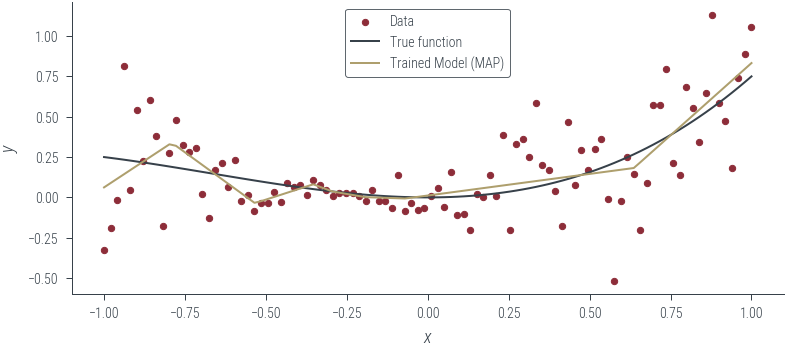

In [306]:
# Plot the trained model (MAP)
plot_model_1(model_7, "Trained Model (MAP)", log_noise_param=fixed_log_noise_std, aleatoric=False)

In [307]:
model_7.fc3.weight.numel()

10

In [314]:
# Hessian of the negative log joint last layer wrt model.fc3.weight

torch.autograd.functional.hessian(lambda x: negative_log_joint_last_layer(model_7, 
                                                                          x_lin[:, None], 
                                                                          y, 
                                                                          fixed_log_noise_std),
                                                                            model_7.fc3.weight)

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]], device='cuda:0')

In [271]:
la = Laplace(model_7, 'regression', subset_of_weights='all', hessian_structure='full')


In [272]:
la

In [274]:
la.sigma_noise = 0.0

In [275]:
la.sigma_noise

tensor(0., device='cuda:0')

In [284]:
la.H

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [285]:
la.H.shape

torch.Size([141, 141])

In [287]:
# Total number of parameters
n_params = sum(p.numel() for p in model_7.parameters())
n_params

141